#Start here


In [1]:
!pip install roboflow
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.8/823.8 kB 8.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
 

In [2]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np
import zipfile
from roboflow import Roboflow
import torch
from torchvision import transforms
from PIL import Image, ImageDraw
import tensorboard

#Accessing Dataset from Roboflow

In [3]:


rf = Roboflow(api_key="IYwf0SjALphOAs60cx0U")
project = rf.workspace("myworkspace-zkmzj").project("license-plate-detector-no-brand")
version = project.version(2)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.63, to fix: `pip install ultralytics==8.0.196`
Exporting format yolov8 in progress : 85.0%
Version export complete for yolov8 format



Extracting Dataset Version Zip to License-Plate-Detector---no-brand-2 in yolov8:: 100%|██████████| 9032/9032 [00:04<00:00, 1966.03it/s]


#View Some of the training images

In [4]:
# # Define paths to your dataset folders
train_folder = "License-Plate-Detector---no-brand-2/train/"
test_folder = "License-Plate-Detector---no-brand-2/test/"
val_folder = "License-Plate-Detector---no-brand-2/valid/"

# # Get list of all image files in the images folder
train_image_files = sorted(os.listdir(os.path.join(train_folder, "images")))
train_annotation_files = sorted(os.listdir( os.path.join(train_folder, "labels"))) # format is each line has class, top left x, top left y, bot right x, bot right y

test_image_files = sorted(os.listdir(os.path.join(test_folder, "images")))
test_annotation_files = sorted(os.listdir( os.path.join(test_folder, "labels")))

val_image_files = sorted(os.listdir(os.path.join(val_folder, "images")))
val_annotation_files = sorted(os.listdir( os.path.join(val_folder, "labels")))



In [5]:
class_names = ['Car', 'Plate']
# colours = np.random.uniform(0,255, size=(len(class_names),3)).astype(int)
colours = [(168,79,132),(139,47,247),(197,239,228)]

In [6]:
# converts yolo formatted bounding box to a cv2 possible bounding box
# yolo format is center of the rectangle or something stupid
def yolo2bbox(bboxes):
  xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
  xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
  return xmin, ymin, xmax, ymax #becomes the top left and bottom right corner

In [7]:
import matplotlib.pyplot as plt
import cv2
import random

def plot_box(image, bboxes, labels):
    for bbox, label in zip(bboxes, labels):
        x_c, y_c, w, h = bbox
        x1 = int((x_c - w / 2) * image.shape[1])
        y1 = int((y_c - h / 2) * image.shape[0])
        x2 = int((x_c + w / 2) * image.shape[1])
        y2 = int((y_c + h / 2) * image.shape[0])
        cv2.rectangle(image, (x1, y1), (x2, y2), colours[int(label)], 2)
        # cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    return image
def plot_image(image_paths, label_paths, num_samples):
    num_images = len(image_paths)
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0, num_images - 1)
        image = cv2.imread(train_folder + "/images/" + image_paths[j])
        with open(train_folder + "/labels/" + label_paths[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for line in label_lines:
                label = line[0]
                bbox_string = line[2:].strip()  # strip to remove any extra spaces/newlines
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
            new_img = plot_box(image, bboxes, labels)
            plt.subplot(2, 2, i + 1)
            plt.imshow(new_img[:, :, ::-1])
            plt.axis('off')

    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()


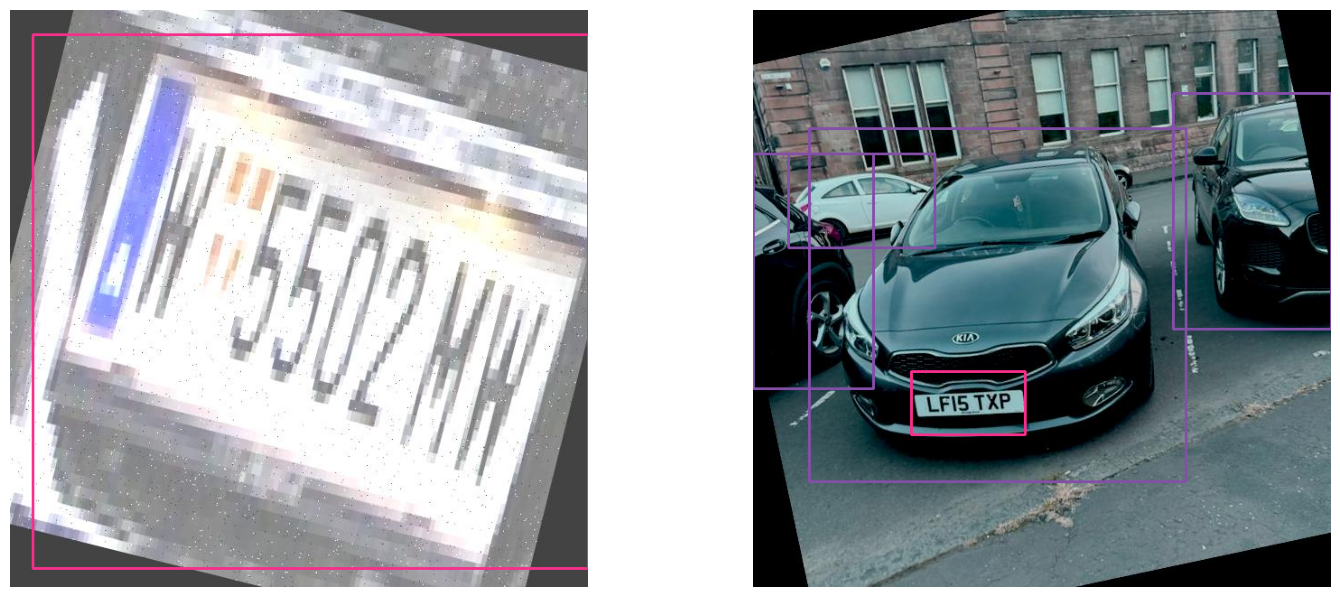

In [8]:
plot_image(image_paths=train_image_files, label_paths=train_annotation_files, num_samples=2)

#Loading and training Yolov8 nano

In [12]:
%cd License-Plate-Detector---no-brand-2/

/content/License-Plate-Detector---no-brand-2


In [13]:
%ls

data.yaml  README.dataset.txt  README.roboflow.txt  test/  train/  valid/


In [14]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Train the model --> need to add /content/ to the front of the train and val paths in data.yml
model.train(data="data.yaml", epochs=10)

100%|██████████| 6.25M/6.25M [00:00<00:00, 136MB/s]


Ultralytics YOLOv8.2.63 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_

100%|██████████| 755k/755k [00:00<00:00, 24.6MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/License-Plate-Detector---no-brand-2/train/labels... 4014 images, 2 backgrounds, 0 corrupt: 100%|██████████| 4014/4014 [00:01<00:00, 2058.39it/s]


train: New cache created: /content/License-Plate-Detector---no-brand-2/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1317, len(boxes) = 10063. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/License-Plate-Detector---no-brand-2/valid/labels... 350 images, 0 backgrounds, 0 corrupt: 100%|██████████| 350/350 [00:00<00:00, 704.16it/s]


val: New cache created: /content/License-Plate-Detector---no-brand-2/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 156, len(boxes) = 916. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.48G      1.222      1.859      1.449         45        640: 100%|██████████| 251/251 [01:37<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.34it/s]

                   all        350        916       0.78      0.723      0.754      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.26G      1.242      1.305      1.456         29        640: 100%|██████████| 251/251 [01:30<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.59it/s]

                   all        350        916      0.768       0.63       0.73      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       2.3G      1.237      1.127       1.46         33        640: 100%|██████████| 251/251 [01:25<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.55it/s]

                   all        350        916      0.835      0.761      0.815      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.26G      1.186      1.009       1.42         27        640: 100%|██████████| 251/251 [01:31<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]

                   all        350        916      0.757      0.753      0.774      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.25G      1.125     0.9155      1.372         36        640: 100%|██████████| 251/251 [01:28<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.56it/s]

                   all        350        916      0.898      0.809      0.881      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.27G      1.063     0.8443      1.324         26        640: 100%|██████████| 251/251 [01:31<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]

                   all        350        916       0.87      0.826      0.872      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.27G      1.029     0.7961      1.296         46        640: 100%|██████████| 251/251 [01:31<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]

                   all        350        916      0.891      0.822      0.887      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.26G     0.9812     0.7396      1.261         31        640: 100%|██████████| 251/251 [01:30<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]

                   all        350        916       0.87      0.844      0.886      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.25G     0.9417      0.698      1.226         46        640: 100%|██████████| 251/251 [01:36<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]

                   all        350        916      0.873      0.869      0.903      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.25G     0.9086     0.6492      1.203         35        640: 100%|██████████| 251/251 [01:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.69it/s]

                   all        350        916      0.883      0.861      0.899      0.668



10 epochs completed in 0.274 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.63 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


                   all        350        916      0.883      0.861      0.899      0.668
                   Car        128        414      0.863      0.903      0.945      0.751
                 Plate        348        502      0.903      0.819      0.854      0.585
Speed: 0.5ms preprocess, 3.6ms inference, 0.0ms loss, 6.5ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff7e2397820>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

#Evaluating the model on the test set

In [15]:
metrics = model.val(data='data.yaml', split='test')  # evaluate model performance on the test set


Ultralytics YOLOv8.2.63 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/License-Plate-Detector---no-brand-2/test/labels... 146 images, 0 backgrounds, 0 corrupt: 100%|██████████| 146/146 [00:00<00:00, 2204.25it/s]

val: New cache created: /content/License-Plate-Detector---no-brand-2/test/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 47, len(boxes) = 317. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


                   all        146        317      0.907      0.793      0.864      0.678
                   Car         61        125      0.866      0.831      0.877      0.734
                 Plate        146        192      0.948      0.756      0.852      0.623
Speed: 0.3ms preprocess, 9.6ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/detect/train2


In [16]:
metrics.box.map  # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps  # a list contains map50-95 of each category

array([    0.73371,     0.62301])

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [19]:
#Save the model
import shutil
best_weights = '/content/License-Plate-Detector---no-brand-2/runs/detect/train/weights/best.pt'
model_path = '/content/License-Plate-Detector---no-brand-2/yolov8n.pt'
drive_path = '/content/gdrive/My Drive/MSc Project/Saved Models/yolov8n.pt'

shutil.copy(best_weights, drive_path)

'/content/gdrive/My Drive/MSc Project/Saved Models/yolov8n.pt'

In [20]:
from ultralytics import YOLO

trained_model = YOLO(drive_path)

#Trying trained model

In [21]:
def load_image(img_path):
    img = Image.open(img_path)
    img = transforms.ToTensor()(img).unsqueeze(0)
    return img

img_path = "/content/"+test_folder+"/images/"+test_image_files[0]
img = load_image(img_path)

# trained_model.eval()
with torch.no_grad():
  detection = trained_model(img)


0: 640x640 3 Plates, 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 14.2ms postprocess per image at shape (1, 3, 640, 640)


In [22]:
bbox = detection[0].boxes
bbox

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 1., 1.], device='cuda:0')
conf: tensor([0.5533, 0.4481, 0.4023], device='cuda:0')
data: tensor([[4.8234e+02, 1.6732e+02, 6.3920e+02, 3.9746e+02, 5.5334e-01, 1.0000e+00],
        [3.8005e+02, 4.9122e+02, 5.5215e+02, 6.3766e+02, 4.4815e-01, 1.0000e+00],
        [3.3566e-01, 1.8934e+02, 2.5524e+02, 4.1537e+02, 4.0233e-01, 1.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([3, 6])
xywh: tensor([[560.7688, 282.3914, 156.8601, 230.1375],
        [466.0953, 564.4383, 172.0997, 146.4434],
        [127.7892, 302.3559, 254.9071, 226.0284]], device='cuda:0')
xywhn: tensor([[0.8762, 0.4412, 0.2451, 0.3596],
        [0.7283, 0.8819, 0.2689, 0.2288],
        [0.1997, 0.4724, 0.3983, 0.3532]], device='cuda:0')
xyxy: tensor([[4.8234e+02, 1.6732e+02, 6.3920e+02, 3.9746e+02],
        [3.8005e+02, 4.9122e+02, 5.5215e+02, 6.3766e+02],
        [3.3566e-01, 1.8934e+02, 2.5524e+02, 4.1537e

In [23]:
bbox.conf[1].item()


0.448147714138031

In [24]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

# Function to load image
def load_image(img_path):
    img = Image.open(img_path)
    img = transforms.ToTensor()(img).unsqueeze(0)
    return img

# Function to plot detections
def plot_detections(img, detections):
    img = transforms.ToPILImage()(img.squeeze(0))
    draw = ImageDraw.Draw(img)
    # Extract bounding boxes from detections
    boxes = detections[0].boxes.xyxy.cpu().numpy()
    # Iterate through the boxes
    cropped_img = None
    for i, box in enumerate(boxes):
      x1, y1, x2, y2 = box[:4]  # Extract coordinates
      conf = detections[0].boxes.conf[i].item()  # Extract confidence score
      label = int(detections[0].boxes.cls[i].item()) # Extract label (if available)
      if label == 1:
        cropped_img = img.crop((x1-5,y1-5, x2+5,y2+5))
        cropped_img = np.array(cropped_img)
      # Draw bounding box
      draw.rectangle([x1, y1, x2, y2], outline='red', width=1)
      # print(x1,y1,x2,y2)
      draw.text((x1, y1-15), f'{label}, {conf:.2f}', fill='red')

    f, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(np.array(img))
    # if cropped_img is not None:
    ax[1].imshow(cropped_img)
    # else:
    ax[1].axis('off')
    plt.axis('off')
    plt.show()

# Load image
img_path = "/content/"+test_folder+"/images/"+test_image_files[25]
img = load_image(img_path)

# Assuming 'detections' is your Results object
# Perform inference and get detections
with torch.no_grad():
    detections = model(img)

# Plot detections
plot_detections(img, detections)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
img_path = "/content/"+test_folder+"/images/"+test_image_files[0]
